In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import sparse as sp
from scipy.sparse.linalg import lsqr
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Question 1: Constructing X

In [2]:
def construct_X(M, alphas, Np=None):
    # calculating Np if not given
    if Np == None:
        Np_estimate = int(np.floor(np.sqrt(2)*M))
        Np = Np_estimate if Np_estimate % 2 == 1 else Np_estimate + 1
        print('Use Np={:d}'.format(Np))
        
    # defining the dimensions
    D = M*M
    N = Np * len(alphas)
    # creating the normal vectors
    n = np.array([[np.cos(alpha*np.pi/180), -np.sin(alpha*np.pi/180)] for alpha in alphas])
    # coordinates of detector rotation center
    # M - 1, because indexing starting from 0
    s0 = np.array([(M-1)/2, (M-1)/2])
    
    beta_flat_index = np.arange(D) # just an array with all indices of beta
    
    # C contains the vector from center of rotation to beta element
    C = np.empty((2, D)) # create C
    C[0,:] = -s0[0] + np.mod(beta_flat_index, M) # x-value: x(beta) = modulo
    C[1,:] = -s0[1] + np.floor_divide(beta_flat_index, M) #y-value: y(beta) = floor_division
    
    
    #fig, ax = plt.subplots(1, 1)
    #ax.quiver([s0[0] for _ in range(D)], [s0[1] for _ in range(D)], C[0], C[1], angles='xy', scale_units='xy', scale=1)
    #ax.set_xlim(-1, M)
    #ax.set_ylim(-1, M)
    #ax.set_title('Construction of C')
    #plt.show()
    
    #fig, ax = plt.subplots(1, 1)
    #for i in range(len(alphas)):
    #    ax.quiver(s0[0], s0[1], n[i][0], n[i][1], angles='xy', scale_units='xy', scale=1)
    #ax.set_xlim(s0[0]-1.2, s0[0]+1.2)
    #ax.set_ylim(s0[1]-1.2, s0[1]+1.2)
    #ax.set_title('Alphas')
    #plt.show()
    
    # np.tensordot gives the projected length of C vectors on
    # Since they are measured from the rotation center, 0 corresponds to the rotation center (located at a length of Np/2)
    p = (Np-1)/2 - np.tensordot(n, C, axes=((1), (0)))
    # TODO: what to do with values smaller than 0?
    
    # calculate weights and indices
    # detector_index_1 is the integral part of p, i.e. the first (most left) sensor the beta element is contributing to
    # beta is contributing to detector_index_1 with weight_1 = 1 - weight_2, where weight_2 is the fraction inside the most neighbouring sensor element
    # therefore weight_2 is the fractional part of p
    # the neighbouring element of detector_index_2 is the one right of it, so just + 1
    weight_2, detector_index_1 = np.modf(p)
    weight_1 = 1 - weight_2
    detector_index_2 = detector_index_1 + 1
    
    # now it can happen, that some are out of bounds. Here we just replace these values with weight 0
    # TODO: performance?
    mask_detector_index_1 = np.logical_or(detector_index_1 < 0, detector_index_1 >= Np)
    weight_1[mask_detector_index_1] = 0
    detector_index_1[mask_detector_index_1] = 0 # just to avoid later errors
    mask_detector_index_2 = np.logical_or(detector_index_2 < 0, detector_index_2 >= Np)
    weight_2[mask_detector_index_2] = 0
    detector_index_2[mask_detector_index_2] = 0 # just to avoid later index errors
    
    
    # merge arrays
    weights = np.array([])
    weights = np.append(weights, [weight_1[angle_index] for angle_index in range(len(alphas))])
    weights = np.append(weights, [weight_2[angle_index] for angle_index in range(len(alphas))])
    # this is what is called i_indices
    detector_indices = np.array([])
    detector_indices = np.append(detector_indices, [Np*angle_index + detector_index_1[angle_index] for angle_index in range(len(alphas))])
    detector_indices = np.append(detector_indices, [Np*angle_index + detector_index_2[angle_index] for angle_index in range(len(alphas))])
    
    # create j indices
    beta_indices = np.array([])
    # we have to flip the beta_flat_index array, because otherwise the picture is upside down
    beta_indices = np.append(beta_indices, [beta_flat_index[::-1] for _ in range(len(alphas))])
    beta_indices = np.append(beta_indices, [beta_flat_index[::-1] for _ in range(len(alphas))])
    
    # i hope duplicate entries will sum
    X = sp.coo_matrix((weights, (detector_indices, beta_indices)), shape=(N, D), dtype = numpy.float32)
    return X

## Checking example

In [3]:
# There is a mistake in the exercise sheet. The provided example is Np=15 (result of estimation) and not 9
example_x = construct_X(10, [-33, 1, 42])#, Np=9)
# compare with provided
provided_example_x = np.load('hs_tomography/X_example.npy')
print('Me == Example?: ', np.array_equal(example_x.toarray(), provided_example_x))

Use Np=15
Me == Example?:  True


# Question 2: Recovering low-res image

In [4]:
alphas_77 = np.load('hs_tomography/alphas_77.npy')
y_77 = np.load('hs_tomography/y_77.npy')
t0 = time.time()
x_77 = construct_X(77, alphas_77, 109)
t1 = time.time()
print('Constructed X in {:f}s'.format(t1 - t0))
# you are free to increase accurancy
beta_77 = lsqr(x_77, y_77, atol=1e-5, btol=1e-5)[0]
t2 = time.time()
print('Solved for beta in {:f}s'.format(t2 - t1))

Constructed X in 0.074499s
Solved for beta in 1.023779s


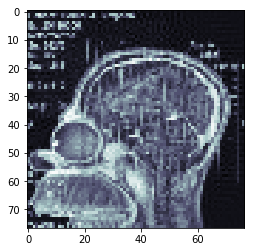

In [5]:
fig, ax = plt.subplots(1, 1)
ax.imshow(beta_77.reshape(77, 77), cmap='bone')
plt.show()

# Question 3: High-res image

In [6]:
alphas_195 = np.load('hs_tomography/alphas_195.npy')
y_195 = np.load('hs_tomography/y_195.npy')
t0 = time.time()
x_195 = construct_X(195, alphas_195, 275)
t1 = time.time()
print('Constructed X in {:f}s'.format(t1 - t0))
# you are free to increase accurancy
beta_195 = lsqr(x_195, y_195, atol=1e-6, btol=1e-6)[0]
t2 = time.time()
print('Solved for beta in {:f}s'.format(t2 - t1))

Constructed X in 0.939594s
Solved for beta in 124.398597s


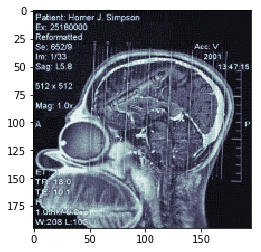

In [7]:
fig, ax = plt.subplots(1, 1)
ax.imshow(beta_195.reshape(195, 195), cmap='bone')
plt.show()